In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from MeanGroupImputer import MeanGroupImputer

%matplotlib inline

# Part 1. Exploratory Data Analysis (EDA) and Feature Engineering <a class="anchor" id="part1"></a>


### The goal
Explore the data, fix NAs, check if there are some mistakes and outliers, preprocess and select relevant features before fitting the model.


It contains information about the passangers of the Titanic. The target variable that we are going to predict is `Survived`. It is a binary variable which indicates whether a given passenger survived in the Titanic catastroph.

In [3]:
titanic = pd.read_csv('data/titanic.csv')
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


We have data for Titanic passengers, the goal is to predict the column `Survived`.

## 1.1 Explore the target <a class="anchor" id="target"></a>

To begin with, let us plot the barplot for the traget variable. It is very convenient to use wrapper around `matplotlib` provided by `pandas`. You can read about it [here](https://pandas.pydata.org/pandas-docs/stable/user_guide/cookbook.html#cookbook-plotting).

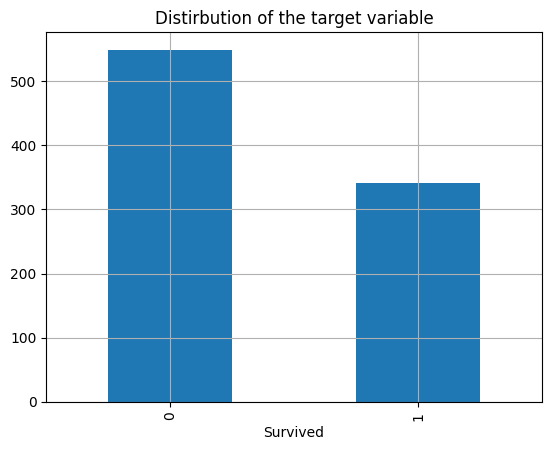

In [4]:
titanic.Survived.value_counts().plot(kind='bar')
plt.grid()
plt.title('Distirbution of the target variable');

---
## 1.2 Explore categorical features <a class="anchor" id="cat_features"></a>


We will start from creating a new feature called `Title`. By the title we mean the name prefix, such as `Mr`, `Miss`, `Dr` etc. It may tell us a lot about age or family status of the passenger even if this information is missing from the dataset.

Let us take a look at some of the `Name` values. You can see that for each passenger name is organised as:

```
Surname, Title. Name
```

In [5]:
titanic.Name[:10]

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
5                                     Moran, Mr. James
6                              McCarthy, Mr. Timothy J
7                       Palsson, Master. Gosta Leonard
8    Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)
9                  Nasser, Mrs. Nicholas (Adele Achem)
Name: Name, dtype: object

In [6]:
# your code here
titanic["Title"]=titanic.Name.str.split(",",expand=True)[1].str.split(".",expand=True)[0]
titanic["Title"] = titanic["Title"].str.strip()
titanic["Title"]

0        Mr
1       Mrs
2      Miss
3       Mrs
4        Mr
       ... 
886     Rev
887    Miss
888    Miss
889      Mr
890      Mr
Name: Title, Length: 891, dtype: object

In [7]:
print(titanic['Title'].value_counts())

assert titanic['Title'].value_counts().shape[0] == 17, 'Wrong number of unique titles. 17 is expected'
assert titanic['Title'].value_counts().Mr == 517, 'Wrong number of passengers with the Title `Mr`. 517 is expected'
assert titanic['Title'].value_counts().Miss == 182, 'Wrong number of passengers with the Title `Miss`. 182 is expected'
assert titanic['Title'].value_counts().Dr == 7, 'Wrong number of passengers with the Title `Dr`. 7 is expected'
names = ['Newell, Miss. Madeleine', 'Gale, Mr. Shadrach', 'Moubarek, Master. Halim Gonios ("William George")']
titles = ['Miss', 'Mr', 'Master']
for n, t in zip(names, titles):
    assert titanic.Title[titanic.Name == n].values == t, 'Wrong title for the passenger {}'.format(n)

Title
Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Mlle              2
Major             2
Col               2
the Countess      1
Capt              1
Ms                1
Sir               1
Lady              1
Mme               1
Don               1
Jonkheer          1
Name: count, dtype: int64


<a class="anchor" id="task2"></a>
You can see that some titles are very rare, which makes their usefulness questionable. We will now combine all the titles which has 6 or less observations into one category called `Other`.
Create a vector `proper_titles` which contains all titles with > 6 observations. For all the passengers, who have title not from the `proper_titles` list, rename their `Title` to `Other`.

In [8]:
# your code here
proper_titles = []
proper_titles += titanic['Title'].value_counts().loc[titanic['Title'].value_counts() > 6].index.to_list()
print(proper_titles)
titanic['Title'] = titanic['Title'].astype('category')
others = titanic['Title'].value_counts().loc[titanic['Title'].value_counts() <=6 ].index
label = 'Other'
titanic['Title'] = titanic['Title'].cat.add_categories([label])
titanic['Title'] = titanic['Title'].replace(others, label)

['Mr', 'Miss', 'Mrs', 'Master', 'Dr']


In [9]:
print(proper_titles)
print()
print(titanic.Title.value_counts())

assert titanic.Title.value_counts().shape[0] == 6
assert sum(titanic.Title == 'Other') == 20
CORRECT_proper_titles = ['Mr', 'Miss', 'Mrs', 'Master', 'Dr']
for p in CORRECT_proper_titles:
    assert p in proper_titles, 'Title {} is expected to be in the list of proper titles'.format(p)

['Mr', 'Miss', 'Mrs', 'Master', 'Dr']

Title
Mr        517
Miss      182
Mrs       125
Master     40
Other      20
Dr          7
Name: count, dtype: int64


Obtain the list of all the categorical columns (columns with data type `object`). Name this list `categ_columns`.

In [10]:
# your code here
titanic.Title = titanic.Title.astype('object')
categ_columns=[]
for col in titanic.columns:
    if titanic[col].dtype.kind =='O':
        categ_columns.append(col)
categ_columns

['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked', 'Title']

In [11]:
print(categ_columns)

assert 'Title' in categ_columns, 'Columns `Title` not in the list'
assert 'Name' in categ_columns, 'Columns `Name` not in the list'
assert 'Sex' in categ_columns, 'Columns `Sex` not in the list'
assert 'Ticket' in categ_columns, 'Columns `Ticket` not in the list'
assert 'Cabin' in categ_columns, 'Columns `Cabin` not in the list'
assert 'Embarked' in categ_columns, 'Columns `Embarked` not in the list'

['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked', 'Title']


Let us explore these categorical features in more details. We will use method `describe` to obtain some statistics about them.

In [12]:
titanic[categ_columns].describe(include='object')

,Name,Sex,Ticket,Cabin,Embarked,Title
count,891,891,891,204,889,891
unique,891,2,681,147,3,6
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S,Mr
freq,1,577,7,4,644,517


Sometimes, categorical columns contain too many unique values, which do not have a lot of information about the task we are solving. There are cases, when it is possible to extract some useful details from such variables (as we just did with the `Name`). But if you can't it might be better to drop such variable.


---
Remove all the categorical features, which have more than 100 unique values.

P.S. Remove the corresponding columns from the dataframe `titanic` and unpdate list of categorical feature `categ_columns` to contain only categorical features that are left.

In [13]:
# your code here
cat_col_length = len(categ_columns)
i=0
while i < cat_col_length:
    if titanic[categ_columns[i]].nunique() > 100 :
        titanic.drop(categ_columns[i], axis=1, inplace=True)
        categ_columns.pop(i)
        cat_col_length-=1
    else:
        i+=1
categ_columns

['Sex', 'Embarked', 'Title']

In [14]:
print(categ_columns)

titanic[categ_columns].head()

CORRECT_categ = set(['Sex', 'Embarked', 'Title'])
diff = list(CORRECT_categ - set(categ_columns))
assert len(diff) == 0, '`categ_columns` is missing columns'
diff = list(set(categ_columns) - CORRECT_categ)
assert len(diff) == 0, '`categ_columns` has too amny columns'

['Sex', 'Embarked', 'Title']


Let's consider distribution of all the categorical features now

---
For each categorical feature draw two bar plots side by side. On the first plot, height of the bar should depict number of passengers in each category, while on the second, height of the bar should depict propostion of survived passengers in the category.

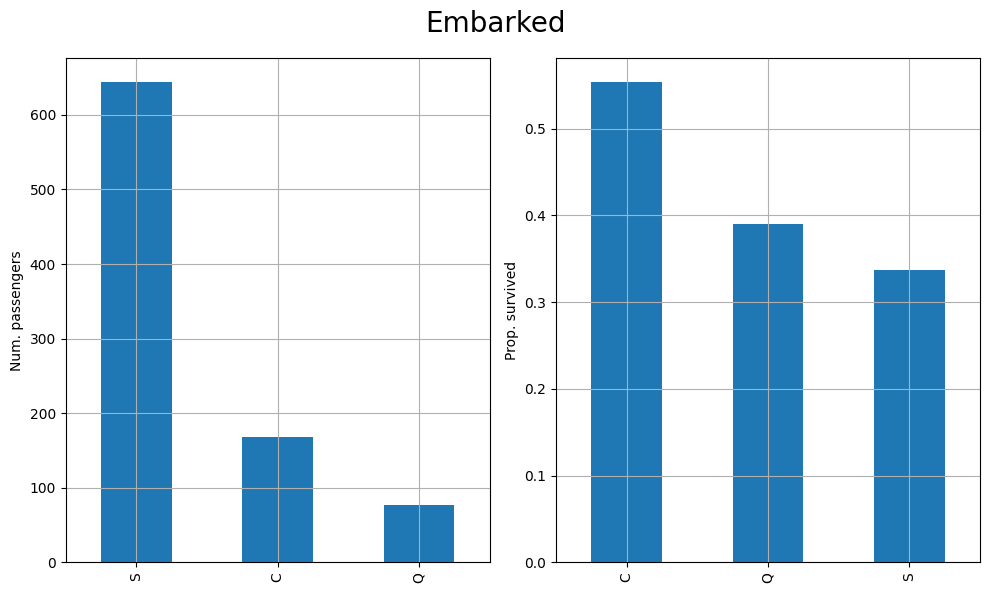

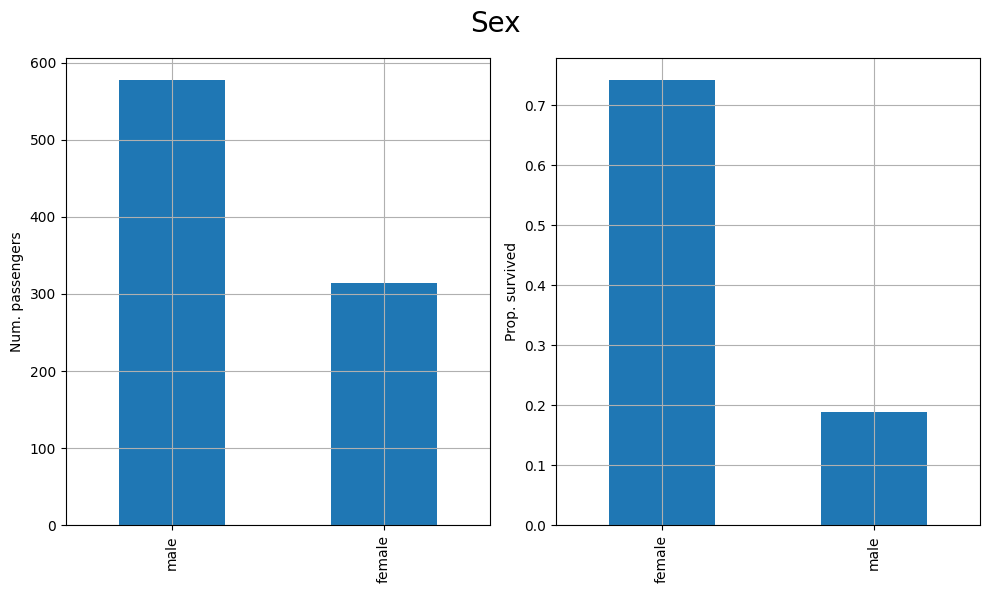

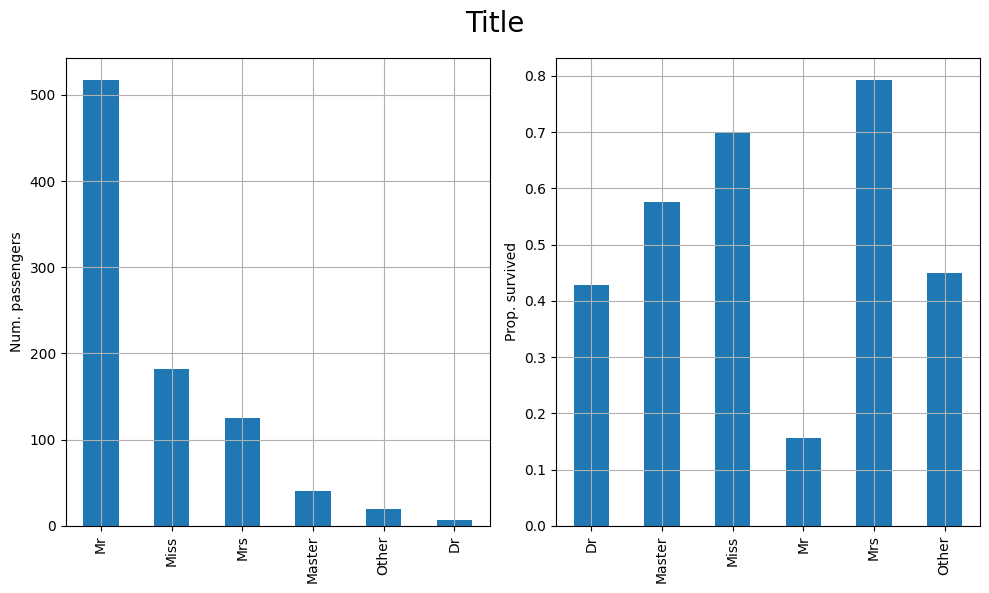

In [15]:
# your code here
rows=len(categ_columns)
columns =['Embarked','Sex','Title']
for row in range(rows):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 6))
    fig.suptitle(columns[row],fontsize=20)
    titanic[columns[row]].value_counts().plot(kind='bar',grid=True,ax = axes[0],subplots=True)
    axes[0].set_title("");
    axes[0].set_ylabel("Num. passengers");
    axes[0].set_xlabel("");
    (titanic.groupby([columns[row]])['Survived'].sum() / titanic.groupby([columns[row]])['Survived'].count()).sort_index().plot(kind='bar',grid=True,ax = axes[1],subplots=True)
    axes[1].set_ylabel("Prop. survived");
    axes[1].set_title("");
    axes[1].set_xlabel("");
    fig.tight_layout()
    fig.subplots_adjust(top=0.9)

---
## 1.3 Ordinal and Numeric Features <a class="anchor" id="rest_features"></a>

Now consider the rest of the dataset. Below you can see the first few observations from all the non-categorical features.

In [16]:
titanic[[c for c in titanic.columns if c not in categ_columns + ['Survived']]].head()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
0,1,3,22.0,1,0,7.2500
1,2,1,38.0,1,0,71.2833
2,3,3,26.0,0,0,7.9250
3,4,1,35.0,1,0,53.1000
4,5,3,35.0,0,0,8.0500


---
We suggest removing the feature `PassengerID` from the dataset. Please do it below and write your comment on why this is a resonalbe thing to do.

In [17]:
# your code here
pass_id_survival_slice = pd.crosstab(titanic["PassengerId"],titanic["Survived"])
titanic.drop("PassengerId", axis=1, inplace=True)

In [18]:
import scipy
from scipy import stats
print(stats.chi2_contingency(pass_id_survival_slice)[1])

0.484248151973633


```PassengerId uniquely identifies each passenger and the the target variable Survived thus does not depend on PassengerId. Also since the PassengerId is a categorical variable where the categories is equal to the number of observations, we cannot infer much information of the target variable survived from it as both of them are independnet. We will validate our hypothesis by using the Chi square test of independence for categorical variables. When we perform chi-square test of independence between PassengerId and the target variable Survived(It satisfies the assumption of Chi square test of independence since PassengerId is a categorical variable and Survived is a binary variable which is also categorical and chi-square test checks whether the two categorical variables are independent or not. Also the values of expected in chi square contigency table are greater than 0 for all the observations under the categorical variables), then we fail to reject the null hypothesis between them. So we can safely remove the unimportant feature from our dataset without affecting the model's learning performance and the model can be trained easily and faster and helps in overcoming the curse of dimensionality and the generalization is enhanced by reducing overfitting. Please find in the above cell the chi square test of independence between the PassengerId and Survived to verify they are independent of each other.From the above cell, we observe the p-value to be 0.48 which is greater than the significance level i.e. ```$\alpha = 0.05$``` thus we fail to reject our null hypothesis stating that the two variables are independent.```

In [19]:
assert 'PassengerId' not in titanic.columns

---
Consider two columns: `SibSp` and `Parch`. The first one is responsibel for number of Siblings/Spouses aboard the Titanic for the given passenger. The second one - number of parents/childer aboard the Titanic. Note that we can create one variable `FamilySize` out of these two.

Create a variable `FamilySize` as a total size of the passenger's family aboard. Remove columns `SibSp` and `Parch` from the dataset afterwards.

In [20]:
# your code here
titanic['FamilySize'] = titanic['SibSp'] + titanic['Parch']
titanic.drop("SibSp", axis=1, inplace=True)
titanic.drop("Parch", axis=1, inplace=True)

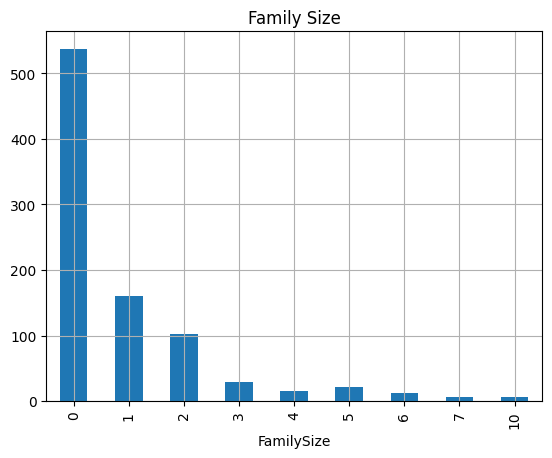

In [21]:
titanic.FamilySize.value_counts().sort_index().plot(kind='bar')
plt.title('Family Size')
plt.grid()

assert 'SibSp' not in titanic.columns
assert 'Parch' not in titanic.columns
assert sum(titanic.FamilySize == 0) == 537
assert sum(titanic.FamilySize == 10) == 7

---
Let us work with the variable `FamilySize` even further. Turns out, that sometimes it is reasonable to convert numerical feature into ordinal ones. E.g. instead of having a family size we can group peopple into `single`, `small_family`, etc. In this manner we can enforce larger distinction between people who do not have family at all and those who have small families. At the same time we can say that for the sake of our application we do not need to distiguish family of size 1 from the family of size 2.

Plot the bar plot for the variable `FamilySize` where the height of the bar is determined by the proportion of the survived passengers. Based on the created plot split all the passengers into tree groups. For each group create a binary variable `FamilySize_1`, `FamilySize_2` and `FamilySize_3`. Justify the split that you've chosen.

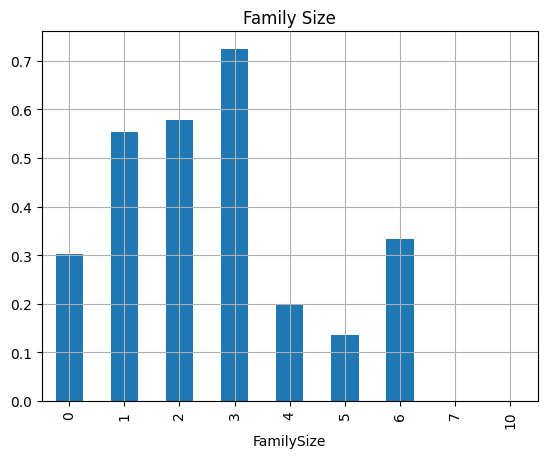

In [22]:
# your code here
total_survived = titanic.Survived.sum()
(titanic.groupby(['FamilySize'])['Survived'].sum() / titanic.groupby(['FamilySize'])['Survived'].count()).sort_index().plot(kind='bar')
plt.title('Family Size')
plt.grid()

In [23]:
titanic['FamilySize'].replace([0, 1, 2, 3, 4, 5, 6, 7, 10], [1,2,2,2,3,3,3,3,3],inplace=True)

In [24]:
from pandas.api.types import CategoricalDtype
cat_dtype = CategoricalDtype(
    categories=[1, 2, 3], ordered=True)
titanic['FamilySize'].astype(cat_dtype)
titanic = pd.concat([titanic,pd.get_dummies(titanic['FamilySize'],prefix='FamilySize')],axis=1)
titanic

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,FamilySize,FamilySize_1,FamilySize_2,FamilySize_3
0,0,3,male,22.0,7.2500,S,Mr,2,False,True,False
1,1,1,female,38.0,71.2833,C,Mrs,2,False,True,False
2,1,3,female,26.0,7.9250,S,Miss,1,True,False,False
3,1,1,female,35.0,53.1000,S,Mrs,2,False,True,False
4,0,3,male,35.0,8.0500,S,Mr,1,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,13.0000,S,Other,1,True,False,False
887,1,1,female,19.0,30.0000,S,Miss,1,True,False,False
888,0,3,female,NaN,23.4500,S,Miss,2,False,True,False
889,1,1,male,26.0,30.0000,C,Mr,1,True,False,False


In [25]:
assert 'FamilySize_1' in titanic.columns
assert 'FamilySize_2' in titanic.columns
assert 'FamilySize_3' in titanic.columns
assert titanic.FamilySize_1.sum() + titanic.FamilySize_2.sum() + titanic.FamilySize_3.sum() == 891
assert titanic.FamilySize_1.sum() > 0
assert titanic.FamilySize_2.sum() > 0
assert titanic.FamilySize_3.sum() > 0

```Based on the plot obtained between the Family Size and the proportion of survived people, we can see the trend of how the proportion of survived people are dependent on the family size from the plot. For the family size 0, proportion of survived is close to 0.3. When the family size increases to 1, there is a spike in the proportion of survived which increases to 0.55. The increasing trend is seen upto the family size of 3. When family size is 4, there is a downward trend in the proportion of survived which decreases to 0.2. Post that there is a decrease and increase seen in the proportion of survived. To split it, the family sizes were sorted in ascending order then the proportion of survival was analyzed and based on its increase/decrease according to the family size, splitting of the family size can be done. So for family size 0 it is the first group, then there is a spike in the proportion of survival for family size 1. Also from family size 1 till 3 there is an increasing trend for the proportion of survival so it can be the second group. When family size is 4 there is a downward trend observed in the proportion of survival. From family size 4 to 10, there is either an increasing or decreasing trend observed in the proportion of survival so it can be the third group. Thus the groups of family size are categorized into the following: Group with family size 0, Group with family size 1 till 3 and Group with family size 4 till 10. Also for the family size 7 and 10 is different from families of size 4,5,6 in proportion of the survival rates, it is not kept as another group because there are few observations in them. The criteria for the demarcation of the groups is the spike/downward trend observed when going along the family sizes in an increasing fashion.```

In [26]:
titanic.drop(['FamilySize'], axis=1, inplace=True)

---
We have three features left unexplored. They are `Pclass`, `Age` and `Fare`. The frist one stands for the ticket class, second - for the age of the passenger and the fird one gives us price of the ticket.

Please, create `ordinal_cols`, which will be list of all the ordinal columns (put there names of relevant columns) and `numeric_cols` - list with the names of the numeric columns. If there is no ordinal or numeric colums, make the corrisponding list empty.

In [27]:
# your code here
ordinal_cols =[]
numeric_cols=[]
columns = ['Pclass','Age','Fare']
for col in columns:
    if titanic[col].dtype.kind =='f':
        numeric_cols.append(col)
    else:
        ordinal_cols.append(col)

In [28]:
print('Ordinal columns are: ', ordinal_cols)
print('Numeric columns are: ', numeric_cols)

assert len(ordinal_cols) == 1
assert len(numeric_cols) == 2
assert 'Pclass' in ordinal_cols
assert 'Age' in numeric_cols
assert 'Fare' in numeric_cols

Ordinal columns are:  ['Pclass']
Numeric columns are:  ['Age', 'Fare']


We can use different plots to explore numerical features. Below you can find some examples with the variable `Age`.  


We can use histograms or boxplots to see how numerical features depends on the categorical one.
1. Age vs Target


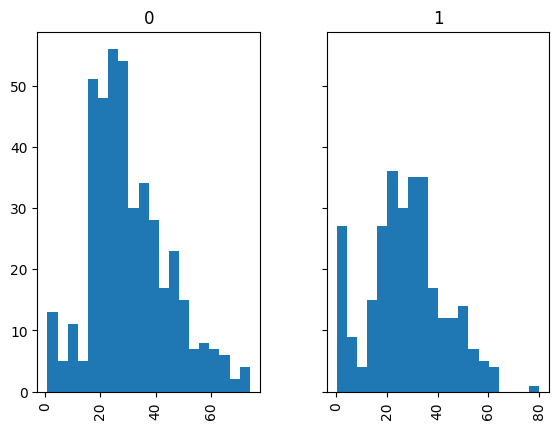


2. Age vs Sex


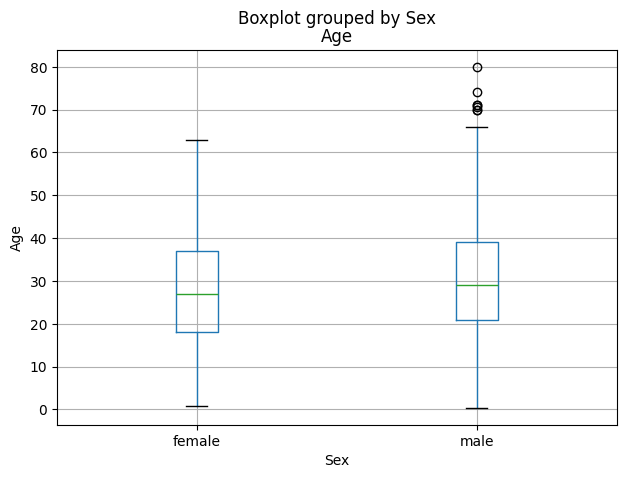

3. Age vs Target


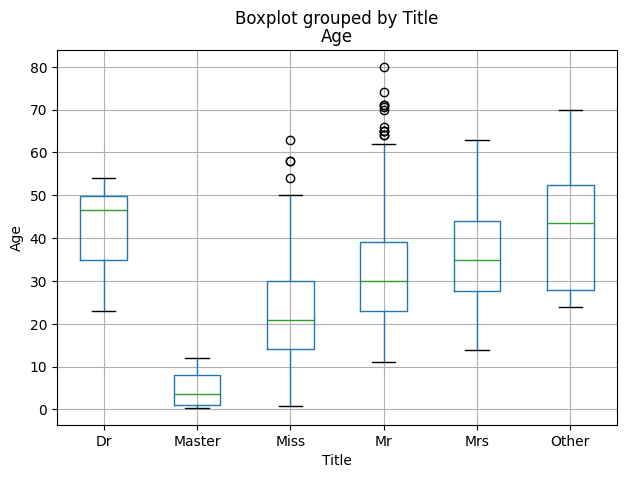


Scatter plots are usefull to spot connection between two numeric features.


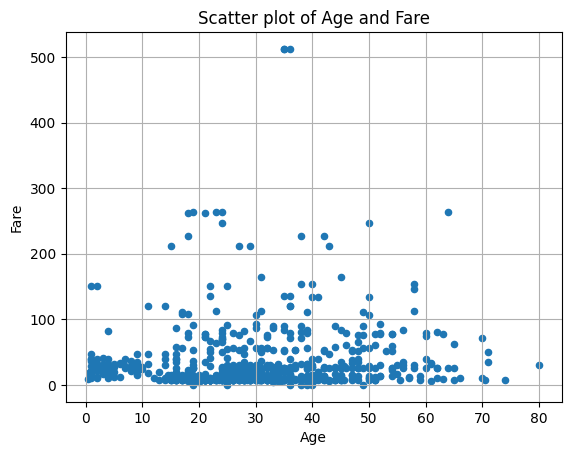

In [29]:
print()
print('We can use histograms or boxplots to see how numerical features depends on the categorical one.')
print('1. Age vs Target')
titanic.hist(column='Age', by='Survived', bins=20, sharey=True);
plt.show();

print()
print('2. Age vs Sex')
titanic.boxplot(column='Age', by='Sex', figsize=(7,5));
plt.ylabel('Age');
plt.show();

print('3. Age vs Target')
titanic.boxplot(column='Age', by='Title', figsize=(7,5));
plt.ylabel('Age');
plt.show();

print()
print('Scatter plots are usefull to spot connection between two numeric features.')
titanic.plot.scatter(x='Age', y='Fare');
plt.grid()
plt.title('Scatter plot of Age and Fare');

---
## 1.3 working with missing values <a class="anchor" id="na"></a>
Compute proportion of missing values in each column. Store the answer in the variable `prop_missing`.


In [30]:
# your code here
prop_missing = titanic.isnull().sum()  / len(titanic)
prop_missing

Survived        0.000000
Pclass          0.000000
Sex             0.000000
Age             0.198653
Fare            0.000000
Embarked        0.002245
Title           0.000000
FamilySize_1    0.000000
FamilySize_2    0.000000
FamilySize_3    0.000000
dtype: float64

In [31]:
# TEST
print('Proportion of missing targets: {:.2f}'.format(prop_missing.Survived))
print('Proportion of missing `Age` values: {:.2f}'.format(prop_missing.Age))

prop_CORRECT = titanic.isnull().sum()/titanic.shape[0]
assert prop_missing.shape[0] == prop_CORRECT.shape[0], 'Wrong number of values'
assert np.allclose(prop_missing.Age, 177./891.), 'Wrong proportion for th ecolumn Age'
assert sum(prop_missing == 0) == sum(prop_CORRECT == 0), 'Wrong number of coumns with 0 missing values'

Proportion of missing targets: 0.00
Proportion of missing `Age` values: 0.20


We have two columns with missing values.


In [32]:
titanic.columns[prop_missing > 0].values

array(['Age', 'Embarked'], dtype=object)

<a class="anchor" id="task11"></a>
What can we do with that? Below you can find some options:
- Fill all the NAs with the same value (mean, median, any other constant)
- Fill NAs using grouping (e.g. we can fill missing in the variable `Fare` for male and female passengers separately using their average value)
- Drop all the rows with missing values
- Drop the whole column (e.g. if there are too many missing values)

The most popular way is to use `SimpleImputer` from sklearn. If fills all the missing values with the same number.

we will implement a more phisticated Imputer. `MeanGroupImputer`. We will make sure that it has proper sklearn interface, so that we can use it within our pipelines. Below you can find the skeleton code for the `MeanGroupImputer`. Please read it carefully to make sure you understand everythig. Your task is to write missing code for the method `transform`.


In [33]:
toy_dataset = pd.DataFrame({'name': ['A','A', 'B','B','B','B', 'C','C','C'],
                            'value': [1, np.nan, 2, np.nan, 3, 1, 3, np.nan, 5],
                            'other_value': [10, np.nan, np.nan, 20, 30, 10, 30, np.nan, 30]})
print(toy_dataset)
imp = MeanGroupImputer(group_col='name')
output = imp.fit_transform(toy_dataset)
print(output)

# test that answers are correct for the toy dataset
assert (output[:, 0] == np.array([1.0, 1.0, 2.0, 2.0, 3.0, 1.0, 3.0, 4.0, 5.0])).all()
assert (output[:, 1] == np.array([10.0, 10.0, 20.0, 20.0, 30.0, 10.0, 30.0, 30.0, 30.0])).all()

correct_out = titanic['Age'].fillna(titanic.groupby('Title')['Age'].transform('mean'))
imp = MeanGroupImputer(group_col='Title')
titanic_copy = titanic.copy()
given_out = imp.fit_transform(titanic[['Title', 'Age']])
assert sum(given_out[:, 0] != correct_out) == 0

  name  value  other_value
0    A    1.0         10.0
1    A    NaN          NaN
2    B    2.0          NaN
3    B    NaN         20.0
4    B    3.0         30.0
5    B    1.0         10.0
6    C    3.0         30.0
7    C    NaN          NaN
8    C    5.0         30.0
[[ 1. 10.]
 [ 1. 10.]
 [ 2. 20.]
 [ 2. 20.]
 [ 3. 30.]
 [ 1. 10.]
 [ 3. 30.]
 [ 4. 30.]
 [ 5. 30.]]


## 1.4 Define column transformers <a class="anchor" id="columns"></a>

In this task we will define columns transformer. Your task is to create three pipelines:
 - `age_pipe`: Pipeline to preprocess column `Age`. It uses `MeanGroupImputer` with the grouping variable `Title` to fill missing values in `Age` and then applies `StandardScaler`
 - `fare_pipe`: Pipeline to preprocess column `Fare`. It applies `StandardScaler` only
 - `categ_pipe`: Pipeline to preprocess all categorical variables. It uses `SimpleImputer` to impute missing values with the most frequent class and then applies `OneHotEncoder`


In [34]:
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import make_pipeline

# your code here
age_pipe = make_pipeline(MeanGroupImputer(group_col='Title'),StandardScaler())
fare_pipe = make_pipeline(StandardScaler())
categ_pipe = make_pipeline(SimpleImputer(strategy="most_frequent"),OneHotEncoder())

# Combine all three pipelines in one column transformer
column_transformer = ColumnTransformer([
 ('age', age_pipe, ['Age', 'Title']),
 ('fare', fare_pipe, ['Fare']),
 ('all_categ', categ_pipe, categ_columns)],
remainder='passthrough'
)

In [35]:
test_titanic = column_transformer.fit_transform(titanic)
print(pd.DataFrame(test_titanic))

assert (pd.DataFrame(test_titanic).isna().sum().values == 0).all()
assert test_titanic.shape[1] == 18, 'Wrong number of columns'

           0         1    2    3    4    5    6    7    8    9    10   11  \
0   -0.584387 -0.502445  0.0  1.0  0.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0   
1    0.621365  0.786845  1.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0   
2   -0.282949 -0.488854  1.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0  0.0   
3    0.395286   0.42073  1.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0   
4    0.395286 -0.486337  0.0  1.0  0.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0   
..        ...       ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
886  -0.20759 -0.386671  0.0  1.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0   
887 -0.810466 -0.044381  1.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0  0.0   
888 -0.601421 -0.176263  1.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0  0.0   
889 -0.282949 -0.044381  0.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0   
890  0.169208 -0.492378  0.0  1.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0   

      12 13 14     15     16     17  
0    0.0  0  3  False   True  False  

## 1.5 Train/test split <a class="anchor" id="train_test"></a>

In [36]:
from sklearn.model_selection import train_test_split

tr, te = train_test_split(titanic, test_size=0.2, random_state=42)

y_train = tr.Survived
y_test = te.Survived
X_train = tr.drop(['Survived'], axis=1)
X_test = te.drop(['Survived'], axis=1)

# 2. Logistic Regression and Support Vector Machine <a class="anchor" id="part2"></a>


## 2.1 Fit Logistic Regression

Define the `log_reg_pipe` - pipeline which applies `column_transformer` and fits logistic regression with the the hyperparameter `penalty='none'` (by default sklearn applies L2 regularization). Calculate the 5-fold cross-validation score (use `accuracy` as a scoring function). Save the result (average accuracy on cross-validation) in the variable `log_reg_score`.

In [37]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
# your code here
log_reg_pipe = Pipeline([
    ('columnTransformer',column_transformer),
    ('logisticRegression',LogisticRegression(penalty='none'))
])
log_reg_score = cross_val_score(log_reg_pipe, X_train, y_train, cv=5,scoring='accuracy').mean()

C:\Users\sumeet\.virtualenvs\MidTermProject-OHSxFT3Z\lib\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\sumeet\.virtualenvs\MidTermProject-OHSxFT3Z\lib\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\sumeet\.virtualenvs\MidTermProject-OHSxFT3Z\lib\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\sumeet\.virtualenvs\MidTermProject-OHSxFT3Z\lib\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past 

In [38]:
log_reg_score

0.8243967300305328

In [39]:
print(log_reg_score)

assert np.allclose(log_reg_score, 0.824, rtol=1e-3)
assert isinstance(log_reg_pipe.steps[0][1], ColumnTransformer)
assert isinstance(log_reg_pipe.steps[1][1], LogisticRegression)

0.8243967300305328


## 2.2 Fit Support Vector Machine

Define the `svm_pipe` - pipeline which applies `column_transformer` and fits Support Vector Machine model (it is imported for you below) using the hyperparameter `kernel='linear'`. Calculate the 5-fold cross-validation score (use `accuracy` as a scoring function). Save the result (average accuracy on cross-validation) in the variable `svm_score`.

In [40]:
from sklearn.svm import SVC

# your code here
svm_pipe = Pipeline([
    ('columnTransformer',column_transformer),
    ('svm',SVC(kernel='linear'))
])
svm_score = cross_val_score(svm_pipe, X_train, y_train, cv=5,scoring='accuracy').mean()

In [41]:
print(svm_score)

assert np.allclose(svm_score, 0.83, rtol=1e-3)
assert isinstance(svm_pipe.steps[0][1], ColumnTransformer)
assert isinstance(svm_pipe.steps[1][1], SVC)

0.8300108342361863


## 2.3 Compare different models

In this task you are supposed to use grid search to find the best classifier for the given dataset. Use `GridSearchCV` class from sklearn. Use 5-Fold cross validation with accuracy as a scoring metric.

*Hints*. Read documentation to see, which hyperparameters `LogisticRegression` and `SVC` have. Pay attention to `kernel` in the SVM model and the regularization coefficient `C` for both LogisticRegression and SVC, try different penalties for `LogisticRegression`. Explore other hyperparameters as well. Your task is to simply get the best accuracy posibe. The minimum passing value will be 0.84 (average score on cross-validaition)

Please, do not use models other that `SVC` or `LogisticRegression`.

In [42]:
from sklearn.model_selection import GridSearchCV

# your code here
param_log_reg_grid = {
    "logisticRegression__C" : np.logspace(-4, 4, 20),
    "logisticRegression__penalty" : ['none', 'l1', 'l2']
}

param_svm_reg_grid = {
    "svm__C" : [3.05],
    "svm__kernel" : ['rbf']
}

# your code here
#grid_pipe = GridSearchCV(log_reg_pipe,param_log_reg_grid,cv=5,scoring='accuracy')
grid_pipe = GridSearchCV(svm_pipe,param_svm_reg_grid,cv=5,scoring='accuracy')
grid_pipe.fit(X_train,y_train)
#grid_pipe.fit(X_tr,y_tr)
print(grid_pipe.best_score_)
print(grid_pipe.best_estimator_.steps[1][1])

0.8426671919629667
SVC(C=3.05)


In [43]:
print(grid_pipe.best_score_)
print(grid_pipe.best_estimator_.steps[1][1])

assert grid_pipe.best_score_ > 0.84
assert isinstance(grid_pipe.best_estimator_.steps[1][1], SVC) or isinstance(grid_pipe.best_estimator_.steps[1][1], LogisticRegression)
test_score = np.mean(cross_val_score(grid_pipe.best_estimator_, X_train, y_train, cv=5, scoring='accuracy'))
assert np.allclose(test_score, grid_pipe.best_score_, rtol=1e-3)

0.8426671919629667
SVC(C=3.05)


## 2.4 Eval best model on test

Now, we can use the best estimator to evaluate model on the test dataset.

1. Fit model on the whole test data
2. Make predictions on the test set
3. Calculate accuracy

In [44]:
from sklearn.metrics import accuracy_score
grid_pipe.best_estimator_.fit(X_train, y_train)
y_pred = grid_pipe.best_estimator_.predict(X_test)
accuracy_score(y_test, y_pred)

0.8268156424581006

In [45]:
import joblib
best_model = grid_pipe.best_estimator_
joblib.dump(best_model, '../model.pkl', compress = 1)

['../model.pkl']

In [46]:
import joblib
model_read = joblib.load('../model.pkl')
y_pred = model_read.predict(X_test)
accuracy_score(y_test, y_pred)

0.8268156424581006